In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#EfficientNetV2 - 2class 학습(ciga, vape)
* 학습 데이터 통합

In [2]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 경로 설정
base_dir = '/content/drive/MyDrive/Colab Notebooks/프로그래머스/3차프로젝트/2class'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 이미지 데이터 제너레이터 설정
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

Found 12030 images belonging to 2 classes.
Found 1156 images belonging to 2 classes.
Found 561 images belonging to 2 classes.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import EfficientNetV2B0
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 레이어 추가
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# 이전 레이어들의 학습을 동결
for layer in base_model.layers:
    layer.trainable = False

# learning_rate = 0.00001
# optimizer = Adam(learning_rate=learning_rate)

#***경로 변경***
model_name = 'EfficientNetV2B0(vape,cigarette)'
checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/'+model_name,
                             monitor='val_loss',
                             save_best_only=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

24274472/24274472 [==============================] - 2s 0us/step


In [4]:
# 모델 학습
history = model.fit(train_generator, epochs=30, validation_data=valid_generator, callbacks = [checkpoint])

Epoch 1/30
376/376 [==============================] - 4433s 12s/step - loss: 0.6991 - accuracy: 0.5263 - val_loss: 0.6928 - val_accuracy: 0.5017
Epoch 2/30
376/376 [==============================] - 85s 227ms/step - loss: 0.6917 - accuracy: 0.5273 - val_loss: 0.6906 - val_accuracy: 0.5320
Epoch 3/30
376/376 [==============================] - 87s 232ms/step - loss: 0.6902 - accuracy: 0.5310 - val_loss: 0.6906 - val_accuracy: 0.5329
Epoch 4/30
376/376 [==============================] - 87s 232ms/step - loss: 0.6892 - accuracy: 0.5389 - val_loss: 0.6896 - val_accuracy: 0.5346
Epoch 5/30
376/376 [==============================] - 87s 230ms/step - loss: 0.6874 - accuracy: 0.5415 - val_loss: 0.6891 - val_accuracy: 0.5355
Epoch 6/30
376/376 [==============================] - 62s 165ms/step - loss: 0.6867 - accuracy: 0.5423 - val_loss: 0.6898 - val_accuracy: 0.5372
Epoch 7/30
376/376 [==============================] - 85s 226ms/step - loss: 0.6852 - accuracy: 0.5505 - val_loss: 0.6864 - val_ac

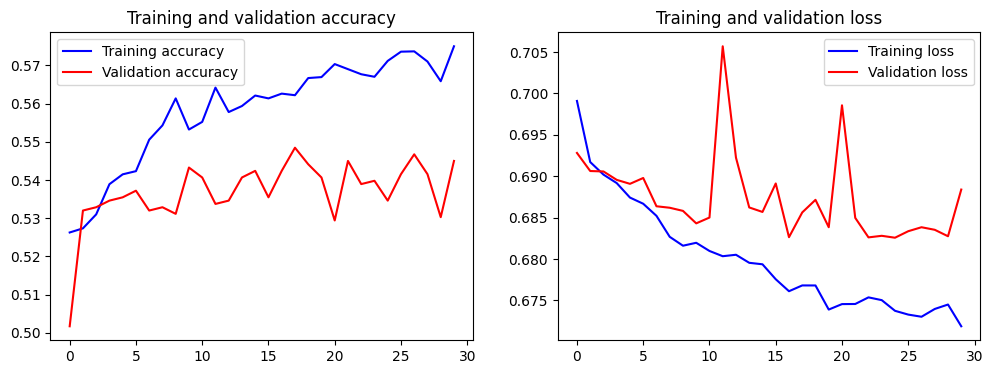

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import time

# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

18/18 [==============================] - 281s 17s/step - loss: 0.6658 - accuracy: 0.5775
Test Accuracy: 0.5775400996208191
18/18 [==============================] - 4s 138ms/step


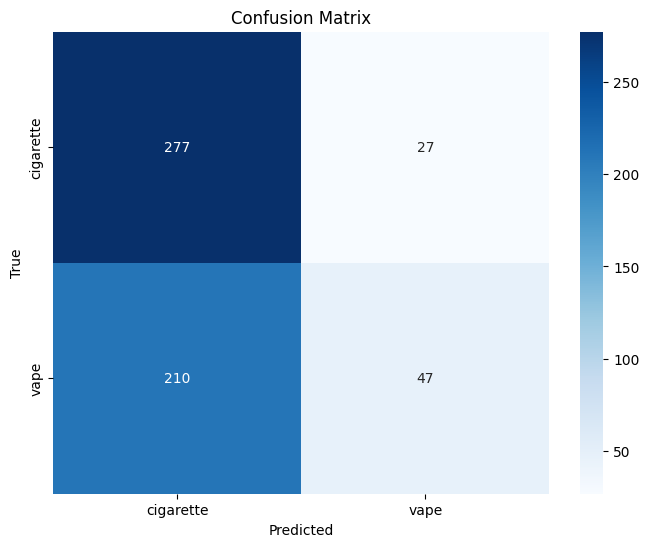

              precision    recall  f1-score   support

   cigarette       0.57      0.91      0.70       304
        vape       0.64      0.18      0.28       257

    accuracy                           0.58       561
   macro avg       0.60      0.55      0.49       561
weighted avg       0.60      0.58      0.51       561

{'cigarette': 0, 'vape': 1}
{0: 'cigarette', 1: 'vape'}


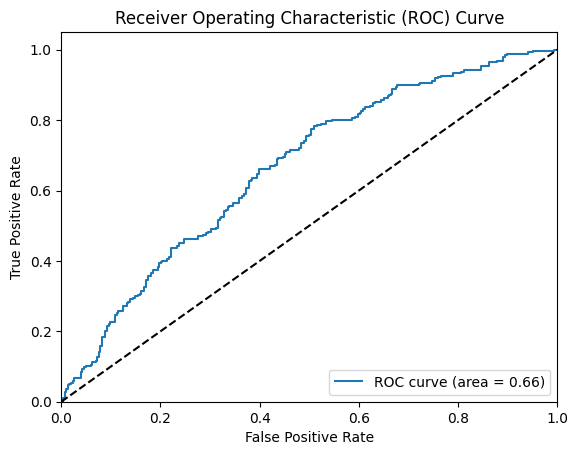

In [6]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()  # 임계값 0.5로 이진화

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)

# 클래스 인덱스 확인
class_indices = train_generator.class_indices
print(class_indices)

# 인덱스와 클래스 이름 매핑
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)

# 레이블 원-핫 인코딩을 원래 레이블로 변환
y_val_labels = test_generator.classes

# 이진 분류의 경우, 하나의 ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(y_val_labels, Y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()